In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [24]:
# =================================================================
# 阶段 1: 建立协议数据库 (我们的“配置中心”)
# =================================================================
# 标称容量 (mAh) 和电压 (V)
NOMINAL_CAPACITY = 3000
NOMINAL_VOLTAGE = 3.6

# 定义每个文件的测试协议
# 这是代码通用化的核心
protocols = {
    'VAH01': {'desc': 'Baseline', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH02': {'desc': 'Extended cruise (1000 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH05': {'desc': '10% power reduction', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 10},
    'VAH06': {'desc': 'CC charge current C/2', 'cc_charge_A': 0.5 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH07': {'desc': 'CV charge voltage 4.0V', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.0, 'power_reduction_pct': 0},
    'VAH09': {'desc': 'Temp: 20 deg C', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH10': {'desc': 'Temp: 30 deg C', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH11': {'desc': '20% power reduction', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 20},
    'VAH12': {'desc': 'Short cruise (400 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH13': {'desc': 'Short cruise (600 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH15': {'desc': 'Extended cruise (1000 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH16': {'desc': 'CC charge current 1.5C', 'cc_charge_A': 1.5 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH17': {'desc': 'Baseline', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH20': {'desc': 'CC charge current 1.5C', 'cc_charge_A': 1.5 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH22': {'desc': 'Extended cruise (1000 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH23': {'desc': 'CV charge voltage 4.1V', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.1, 'power_reduction_pct': 0},
    'VAH24': {'desc': 'CC charge current C/2', 'cc_charge_A': 0.5 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH25': {'desc': 'Temp: 20 deg C', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH26': {'desc': 'Short cruise (600 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH27': {'desc': 'Baseline', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH28': {'desc': '10% power reduction', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 10},
    'VAH30': {'desc': 'Temp: 35 deg C', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH06_new': {'desc': 'CC charge current C/2', 'cc_charge_A': 0.5 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH07_new': {'desc': 'CV charge voltage 4.0V', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.0, 'power_reduction_pct': 0},
    'VAH09_new': {'desc': 'Temp: 20 deg C', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
    'VAH11_new': {'desc': '20% power reduction', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 20},
    'VAH22_new': {'desc': 'Extended cruise (1000 sec)', 'cc_charge_A': 1.0 * NOMINAL_CAPACITY/1000, 'cv_voltage': 4.2, 'power_reduction_pct': 0},
}

In [27]:
def process_battery_file(file_path, protocol, dataset_folder):
    base_filename = os.path.basename(file_path)
    log_filename = base_filename.replace('.csv', '.txt')
    json_filename = os.path.join(dataset_folder, base_filename.replace('.csv', '.json'))
    npz_filename = os.path.join(dataset_folder, base_filename.replace('.csv', '.npz'))

    with open(log_filename, 'w') as log_file:
        log_file.write(f"--- 分析日志 for: {base_filename} ---\n")
        log_file.write(f"--- 协议: {protocol['desc']} ---\n\n")

        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            log_file.write(f"错误: 文件未找到 {file_path}\n")
            return None, None

        # --- 阶段 0: 数据清洗 ---
        GLITCH_LENGTH_THRESHOLD = 5
        change_indices = np.where(df['Ns'].diff() != 0)[0]
        segment_boundaries = sorted(list(set([0] + change_indices.tolist() + [len(df)])))
        segments = []
        for i in range(len(segment_boundaries) - 1):
            start, end = segment_boundaries[i], segment_boundaries[i+1]
            segments.append({'ns': df['Ns'].iloc[start], 'start': start, 'length': end - start})
        indices_to_drop = []
        i = 1
        while i < len(segments) - 1:
            if segments[i]['length'] <= GLITCH_LENGTH_THRESHOLD and segments[i-1]['ns'] == segments[i+1]['ns']:
                glitch_candidate_start_index = i
                j = i
                while j < len(segments) -1 and segments[j]['length'] <= GLITCH_LENGTH_THRESHOLD: j += 1
                if segments[i-1]['ns'] == segments[j]['ns']:
                    for k in range(glitch_candidate_start_index, j):
                        start_idx_to_drop = segments[k]['start']
                        end_idx_to_drop = start_idx_to_drop + segments[k]['length']
                        indices_to_drop.extend(range(start_idx_to_drop, end_idx_to_drop))
                    i = j
                else: i += 1
            else: i += 1
        if indices_to_drop:
            df.drop(indices_to_drop, inplace=True)
            df.reset_index(drop=True, inplace=True)
            log_file.write(f"[高级数据清洗]: 发现并删除了 {len(indices_to_drop)} 个数据点。\n\n")

        df['Power_W'] = (df['Ecell_V'] * df['I_mA']) / 1000.0
        ns_change_indices = df[df['Ns'].diff() != 0].index.tolist()
        segment_boundaries = sorted(list(set([0] + ns_change_indices + [len(df)])))
        
        log_file.write(f"清洗后发现 {len(segment_boundaries) - 1} 个有效片段。\n\n")
        log_file.write(f"{'片段 #':<8} | {'起始时间(s)':<15} | {'持续(s)':<10} | {'状态标签':<35} | {'依据 (I, V, P)'}\n")
        log_file.write("-" * 110 + "\n")
        
        # --- 阶段 1: 宏观扫描，识别片段、提取RPT数据并确定循环边界 ---
        all_labeled_segments = []
        cc_charge_mA = protocol['cc_charge_A'] * 1000; cv_voltage_V = protocol['cv_voltage']
        power_factor = (100 - protocol['power_reduction_pct']) / 100.0
        takeoff_power_W = -54 * power_factor; cruise_power_W = -16 * power_factor
        
        mission_cycle_counter = 0; rpt_capacities, rpt_cycles = [], []
        cycle_boundaries = []; is_currently_in_rpt, just_exited_rpt = False, False
        current_rpt_max_capacity = 0; current_cycle_start_row = 0

        for i in range(len(segment_boundaries) - 1):
            start_idx, end_idx = segment_boundaries[i], segment_boundaries[i+1]
            segment_df = df.iloc[start_idx:end_idx]
            if segment_df.empty: continue
            
            mean_current = segment_df['I_mA'].mean(); mean_voltage = segment_df['Ecell_V'].mean()
            mean_power = segment_df['Power_W'].mean(); start_time = segment_df['time_s'].iloc[0]
            duration = segment_df['time_s'].iloc[-1] - start_time
            phase_label, is_this_segment_an_rpt = "未知/过渡", False

            if -700 < mean_current < -500:
                phase_label, is_this_segment_an_rpt = "RPT: C/5 容量测试放电", True
                current_rpt_max_capacity = max(current_rpt_max_capacity, segment_df['QDischarge_mA_h'].max())
            elif -100 < mean_current < 100:
                if is_currently_in_rpt and 20 < duration < 40:
                    phase_label, is_this_segment_an_rpt = "RPT: IR测量前静置", True
                else: phase_label = "静置 (Rest)"
            elif mean_current > 100:
                if mean_voltage > (cv_voltage_V - 0.05): phase_label = "恒压充电 (CV Charge)"
                elif (cc_charge_mA - 200) < mean_current < (cc_charge_mA + 200): phase_label = "恒流充电 (CC Charge)"
                else: phase_label = "其他充电阶段"
            elif mean_current < -100:
                if (takeoff_power_W-5) < mean_power < (takeoff_power_W+5) and 70 < duration < 80: phase_label = "任务剖面: 起飞 (Take-off)"
                elif (takeoff_power_W-5) < mean_power < (takeoff_power_W+5): phase_label = "任务剖面: 降落 (Landing)"
                elif (cruise_power_W-4) < mean_power < (cruise_power_W+4): phase_label = "任务剖面: 巡航 (Cruise)"
                else: phase_label = "其他放电阶段"
            
            # --- 最终修正：只有 'Take-off' 才是新循环的开始 ---
            is_new_cycle_start = (phase_label == "任务剖面: 起飞 (Take-off)")
            
            if is_new_cycle_start:
                if mission_cycle_counter > 0: # 只有在第一个Mission之后，才记录上一个Mission的结束
                    cycle_boundaries.append({'start_row': current_cycle_start_row, 'end_row': start_idx})
                
                current_cycle_start_row = start_idx # 更新新Mission的起点
                mission_cycle_counter += 1 # Mission计数器加一
                
            if not is_this_segment_an_rpt and is_currently_in_rpt: just_exited_rpt = True
            
            if just_exited_rpt:
                rpt_capacities.append(current_rpt_max_capacity)
                rpt_cycles.append(mission_cycle_counter) # RPT容量关联到当前Mission数
                log_file.write("\n>>> RPT数据点记录: Capacity = {:.2f} mAh, Mission Cycle = {} <<<\n\n".format(current_rpt_max_capacity, mission_cycle_counter))
                current_rpt_max_capacity = 0; just_exited_rpt = False

            is_currently_in_rpt = is_this_segment_an_rpt
            all_labeled_segments.append({'id': i+1, 'label': phase_label, 'time': start_time})
            log_file.write(f"{i+1:<8} | {start_time:<15.2f} | {duration:<10.2f} | {phase_label:<35} | I={mean_current:7.1f}mA, V={mean_voltage:4.2f}V, P={mean_power:6.2f}W\n")
        
        if mission_cycle_counter > 0:
            cycle_boundaries.append({'start_row': current_cycle_start_row, 'end_row': len(df)})
        
        # --- 阶段 2: Mission完整性验证 ---
        # [代码与之前版本相同]
        log_file.write("\n" + "="*40 + "\n")
        log_file.write("--- Mission 完整性验证报告 ---\n")
        MISSION_SEQUENCE_AFTER_TAKEOFF = ['任务剖面: 巡航 (Cruise)', '任务剖面: 降落 (Landing)', '静置 (Rest)', '恒流充电 (CC Charge)', '恒压充电 (CV Charge)', '静置 (Rest)']
        all_violations = []
        for i, segment in enumerate(all_labeled_segments):
            if segment['label'] == '任务剖面: 起飞 (Take-off)':
                if i + 1 + len(MISSION_SEQUENCE_AFTER_TAKEOFF) > len(all_labeled_segments):
                    all_violations.append({'start_segment': segment['id'], 'time': segment['time'], 'type': '数据提前结束', 'expected': '完整的Mission序列', 'actual': '文件在Mission完成前结束'})
                    break
                for j, expected_label in enumerate(MISSION_SEQUENCE_AFTER_TAKEOFF):
                    actual_segment = all_labeled_segments[i + 1 + j]
                    if actual_segment['label'] != expected_label:
                        all_violations.append({'start_segment': segment['id'], 'time': actual_segment['time'], 'type': '顺序错误', 'expected': expected_label, 'actual': actual_segment['label']})
                        break
        if not all_violations: log_file.write("【验证通过】: 所有由'起飞'开始的Mission序列均完整且顺序正确。\n")
        else:
            log_file.write(f"【验证失败】: 发现 {len(all_violations)} 处Mission序列不完整或顺序错误！\n详情如下:\n")
            for viol in all_violations: log_file.write(f"  - 对于从片段 #{viol['start_segment']} 开始的Mission:\n    - 问题发生在 time={viol['time']:.2f}s, 类型: {viol['type']}\n    - 期望: '{viol['expected']}', 实际检测到: '{viol['actual']}'\n")
        log_file.write("="*40 + "\n")
        
        # --- 阶段 3 & 4: 容量插值与数据保存 (JSON & NPZ) ---
        if not rpt_cycles or len(rpt_cycles) < 2:
            log_file.write("\n【错误】: RPT容量数据点不足 (<2)，无法进行插值和数据生成。\n")
            return None, None
            
        total_missions = len(cycle_boundaries)
        all_mission_numbers = np.arange(1, total_missions + 1)
        interpolated_capacities = np.interp(all_mission_numbers, rpt_cycles, rpt_capacities)
        
        json_data, npz_data = [], []
        for i, cycle in enumerate(cycle_boundaries):
            mission_num = i + 1; start_row, end_row = cycle['start_row'], cycle['end_row']
            cycle_sensor_df = df.iloc[start_row:end_row]
            capacity = interpolated_capacities[i]
            
            json_data.append({"mission_number": mission_num, "capacity_mAh": capacity, "sensor_data": cycle_sensor_df.to_dict(orient='records')})
            npz_data.append({'capacity': capacity, 'sensor_data': cycle_sensor_df.values})
            
        with open(json_filename, 'w') as f: json.dump(json_data, f, indent=4)
        np.savez_compressed(npz_filename, missions=np.array(npz_data, dtype=object))

        log_file.write(f"\n【成功】: 已成功提取 {total_missions} 个Mission的数据，并插值了容量。\n")
        log_file.write(f"--> JSON数据已保存到: {json_filename}\n")
        log_file.write(f"--> NPZ数据已保存到: {npz_filename}\n")
        log_file.write("\n--- 分析日志结束 ---\n")
        
        return rpt_cycles, rpt_capacities

--- 正在处理: VAH01.csv ---
--- 完成 VAH01.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH02.csv ---
--- 完成 VAH02.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH05.csv ---
--- 完成 VAH05.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH06_new.csv ---
--- 完成 VAH06_new.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH07_new.csv ---
--- 完成 VAH07_new.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH09_new.csv ---
--- 完成 VAH09_new.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH10.csv ---
--- 完成 VAH10.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH11_new.csv ---
--- 完成 VAH11_new.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH12.csv ---
--- 完成 VAH12.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH13.csv ---
--- 完成 VAH13.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH15.csv ---
--- 完成 VAH15.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH16.csv ---
--- 完成 VAH16.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH17.csv ---
--- 完成 VAH17.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH20.csv ---
--- 完成 VAH20.csv。日志、图片、JSON和NPZ文件已保存。 ---
--- 正在处理: VAH22_new.csv ---
--- 完成 VAH22_new

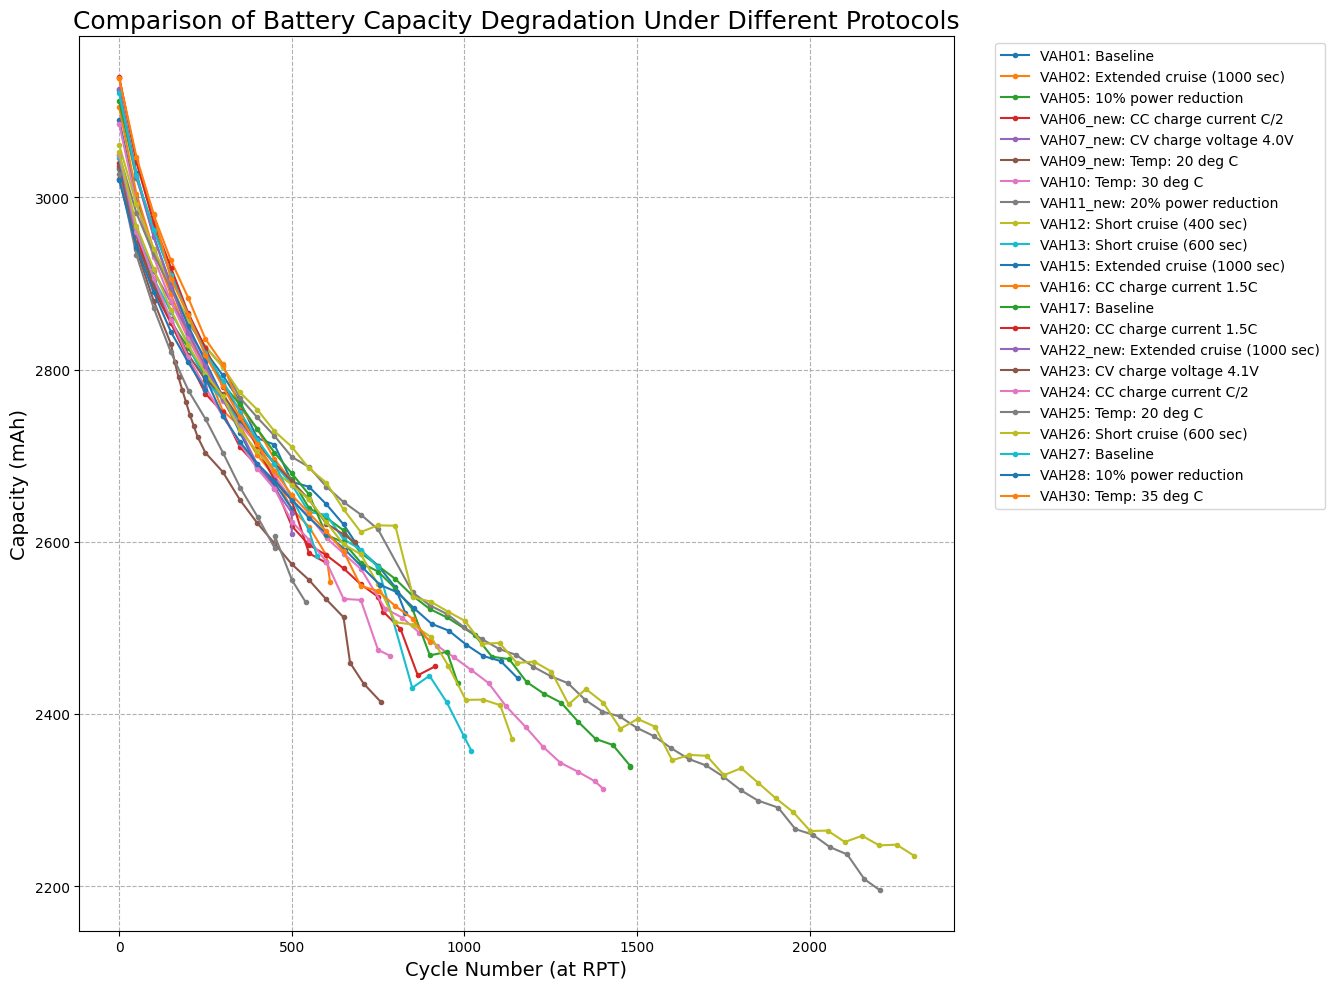

In [28]:
if __name__ == '__main__':
    # 假设CSV文件在一个名为'dataset'的子文件夹中
    # 如果CSV和脚本在同一目录，则设为'.'
    dataset_folder = '../datasets/' 
    all_files = [f for f in os.listdir(dataset_folder) if f.startswith('VAH') and f.endswith('.csv')]
    to_remove = ['VAH06.csv','VAH07.csv','VAH09.csv','VAH11.csv','VAH22.csv']
    for file in to_remove:
        if file in all_files:
            all_files.remove(file)
    
    all_results = {}
    
    for filename in sorted(all_files):
        battery_name = filename.split('.')[0]
        if battery_name in protocols:
            print(f"--- 正在处理: {filename} ---")
            protocol = protocols[battery_name]
            full_path = os.path.join(dataset_folder, filename)
            
            # process_battery_file现在需要知道dataset_folder的位置来保存JSON/NPZ
            rpt_cycles_data, rpt_capacities_data = process_battery_file(full_path, protocol, dataset_folder)
            
            if rpt_cycles_data and rpt_capacities_data:
                all_results[battery_name] = {'cycles': rpt_cycles_data, 'capacities': rpt_capacities_data, 'desc': protocol['desc']}
                
                # 为每个电池生成并保存独立的图
                plt.figure(figsize=(10, 6))
                plt.plot(rpt_cycles_data, rpt_capacities_data, 'o-', label=f'{battery_name} Capacity')
                plt.title(f'Capacity Degradation for {battery_name}: {protocol["desc"]}')
                plt.xlabel('Cycle Number (at RPT)')
                plt.ylabel('Capacity (mAh)')
                plt.grid(True); plt.legend()
                plt.savefig(f'{battery_name}_degradation.png')
                plt.close()
                print(f"--- 完成 {filename}。日志、图片、JSON和NPZ文件已保存。 ---")
            else:
                print(f"--- !!! 未能从 {filename} 提取RPT数据。请检查日志文件。 ---")
        else:
            print(f"--- !!! 警告: 未在协议数据库中找到 {filename} 的配置，已跳过。 ---")

    # --- 绘制并保存最终的汇总对比图 ---
    if all_results:
        print("\n--- 所有文件处理完毕。正在生成汇总对比图... ---")
        plt.figure(figsize=(16, 10))
        for battery_name, result in all_results.items():
            plt.plot(result['cycles'], result['capacities'], '.-', label=f"{battery_name}: {result['desc']}")
        plt.title('Comparison of Battery Capacity Degradation Under Different Protocols', fontsize=18)
        plt.xlabel('Cycle Number (at RPT)', fontsize=14); plt.ylabel('Capacity (mAh)', fontsize=14)
        plt.grid(True, which='both', linestyle='--'); plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.tight_layout(rect=[0, 0, 0.85, 1]); plt.savefig('SUMMARY_degradation_comparison.png')
        print("--- 汇总图 'SUMMARY_degradation_comparison.png' 已保存。 ---")
        plt.show()
    else:
        print("\n--- 未能成功处理任何文件，无法生成汇总图。 ---")